# Model Compression

## Overview

Model Compression using magnitude-based *weight pruning* and *Quantization*.

### Summary

In this tutorial, you will:

1.   Train a `tf.keras` model for MNIST from scratch.
2.   Fine tune the model by applying the pruning API and see the accuracy.
3.   Create 3x smaller TF and TFLite models from pruning.
4.   Create a 10x smaller TFLite model from combining pruning and post-training quantization.
5.   See the persistence of accuracy from TF to TFLite.

## Install Libraries

In [ ]:
! pip install -q tensorflow-model-optimization

In [ ]:
import tempfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Train a model for MNIST without pruning

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images.shape

(60000, 28, 28)

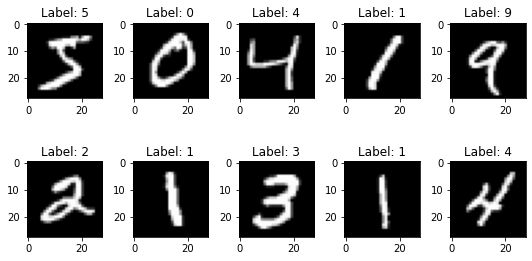

In [ ]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(train_labels[i]))
plt.tight_layout()
plt.show()

## Normalizing the dataset

In [ ]:
# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

## Building and compiling a CNN model for classification

In [ ]:
# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

In [ ]:
# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training and evaluating the model

In [ ]:
model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)

Epoch 1/4
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3198 - accuracy: 0.9084 - val_loss: 0.1523 - val_accuracy: 0.9593
Epoch 2/4
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1353 - accuracy: 0.9613 - val_loss: 0.0911 - val_accuracy: 0.9753
Epoch 3/4
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0933 - accuracy: 0.9729 - val_loss: 0.0777 - val_accuracy: 0.9803
Epoch 4/4
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0747 - accuracy: 0.9781 - val_loss: 0.0651 - val_accuracy: 0.9835


Evaluate baseline test accuracy and save the model for later usage.

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)



Baseline test accuracy: 0.9768999814987183


### Saving the model file 

In [ ]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmpfxjrrri2.h5


## Fine-tune pre-trained model with pruning


### Define the model

You will apply pruning to the whole model and see this in the model summary.

In this example, the pruning will done at 80% sparsity.

In the [comprehensive guide](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide.md), you can see how to prune some layers for model accuracy improvements.

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=-1)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Train and evaluate the model against baseline

Fine tune with pruning for two epochs.

`tfmot.sparsity.keras.UpdatePruningStep` is required during training, and `tfmot.sparsity.keras.PruningSummaries` provides logs for tracking progress and debugging.

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2
422/422 [==============================] - 5s 9ms/step - loss: 0.1808 - accuracy: 0.9546 - val_loss: 0.1157 - val_accuracy: 0.9718
Epoch 2/2
422/422 [==============================] - 3s 7ms/step - loss: 0.1064 - accuracy: 0.9725 - val_loss: 0.0888 - val_accuracy: 0.9782


For this example, there is minimal loss in test accuracy after pruning, compared to the baseline.

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9768999814987183
Pruned test accuracy: 0.972100019454956


The logs show the progression of sparsity on a per-layer basis.

## Create 3x smaller models from pruning

Both `tfmot.sparsity.keras.strip_pruning` and applying a standard compression algorithm (e.g. via gzip) are necessary to see the compression
benefits of pruning.

*   `strip_pruning` is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to model size during inference
*   Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is
added redundancy that algorithms can utilize to further compress the model.

First, create a compressible model for TensorFlow.

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpeb4b0dxd.h5


Then, create a compressible model for TFLite.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpr1ojb_p6/assets
Saved pruned TFLite model to: /tmp/tmp4dq2gzzj.tflite


Define a helper function to actually compress the models via gzip and measure the zipped size.

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

Compare and see that the models are 3x smaller from pruning.

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 78292.00 bytes
Size of gzipped pruned Keras model: 25747.00 bytes
Size of gzipped pruned TFlite model: 25046.00 bytes


## Create a 10x smaller model from combining pruning and quantization

You can apply post-training quantization to the pruned model for additional benefits.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmpxjpalzjh/assets


INFO:tensorflow:Assets written to: /tmp/tmpxjpalzjh/assets


Saved quantized and pruned TFLite model to: /tmp/tmp1wmyv0tc.tflite
Size of gzipped baseline Keras model: 78292.00 bytes
Size of gzipped pruned and quantized TFlite model: 8046.00 bytes


## See persistence of accuracy from TF to TFLite

Define a helper function to evaluate the TF Lite model on the test dataset.

In [ ]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

You evaluate the pruned and quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
print('Pruned TF test accuracy:', model_for_pruning_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Pruned and quantized TFLite test_accuracy: 0.9717
Pruned TF test accuracy: 0.972100019454956
